# Import libraries

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [16]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [17]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [18]:
def norm_filter(adata, mito_genes, RB_genes_in_data, log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [19]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [20]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('DEA/' + cell_type):
        os.makedirs('DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    #adata_celltype = adata_celltype[adata_celltype.obs['final_subclusters'].isin([cell_type]),:]
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)

    
    expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [21]:
def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [22]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [23]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_final_high_var = sc.read_h5ad(outdir+'adata_final_high_var_final_clusters_updated.h5ad')

In [12]:
adata_final_high_var.shape

(23060, 18947)

# Astrocyte subset

In [13]:
adata_astro = deepcopy(adata_final_high_var)
adata_astro = adata_astro[adata_astro.obs['final_subclusters'].isin(['Astrocytes']),:]
adata_astro.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1628, 18947)

In [14]:
broad_clusters = adata_astro.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_astro.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 489, '1819_C1029_Ctrl_ES_Cort_IGO_10837_23': 275})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 550, '1821_996_VE_ES_Cort_IGO_10875_6': 314})


In [15]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [16]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [17]:
adata_astro = adata[adata_astro.obs.index, :]
adata_astro.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1628, 22292)

## QC

In [18]:
adata_astro, mito_genes, RB_genes_in_data = qc_metrics(adata_astro)
markers = []
if type(adata_astro.X)==np.ndarray:
    pass
else:
    print(type(adata_astro.X))
    #print(adata_norm.X.shape)
    adata_astro.X = adata_astro.X.toarray()
    #print(adata_norm.X.shape)
adata_astro.X = pd.DataFrame(data=adata_astro.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [19]:
adata_astro.shape

(1628, 22292)

## Normalization

In [20]:
markers = []
adata_astro, markers = norm_filter(adata_astro, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_astro.obs.head()

(1628, 22292)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1628, 12540)
(1628, 12365)
(1628, 12353)
True
Im here2


Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                              
126913543847340_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3      1820_C1029_Ctrl_ES_BS_IGO_10856_3   

                                                   Condition   B_region  \
cell_barcodes                                                             
126913543847340_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control     Cortex   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3    Control  BrainStem   

                                                    n_genes_by_counts  \
cell_barcodes                                                           
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                    1520   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                    1416   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...               1141   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                    1226   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3                1716   

                                                    log1p_n_genes_by_counts  \
cell_barcodes                                                                 
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                      7.327123   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                      7.256297   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...                 7.040536   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                      7.112327   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3                  7.448334   

                                                    total_counts  \
cell_barcodes                                                      
126913543847340_1822_996_VE_ES_BS_IGO_10875_7             2673.0   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7             2370.0   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...        1900.0   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7             2032.0   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3         3413.0   

                                                    log1p_total_counts  \
cell_barcodes                                                            
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                 7.891331   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                 7.771067   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...            7.550135   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                 7.617268   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3             8.135640   

                                                    pct_counts_in_top_50_genes  \
cell_barcodes                                                                    
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                        23.718668   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                        23.206751   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...                   23.105263   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                        23.917323   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3                    25.080574   

                                                    pct_counts_in_top_100_genes  \
cell_barcodes                                                                     
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                         31.911710   
200991407794422_1822_9

## PCA

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1628, 12353)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


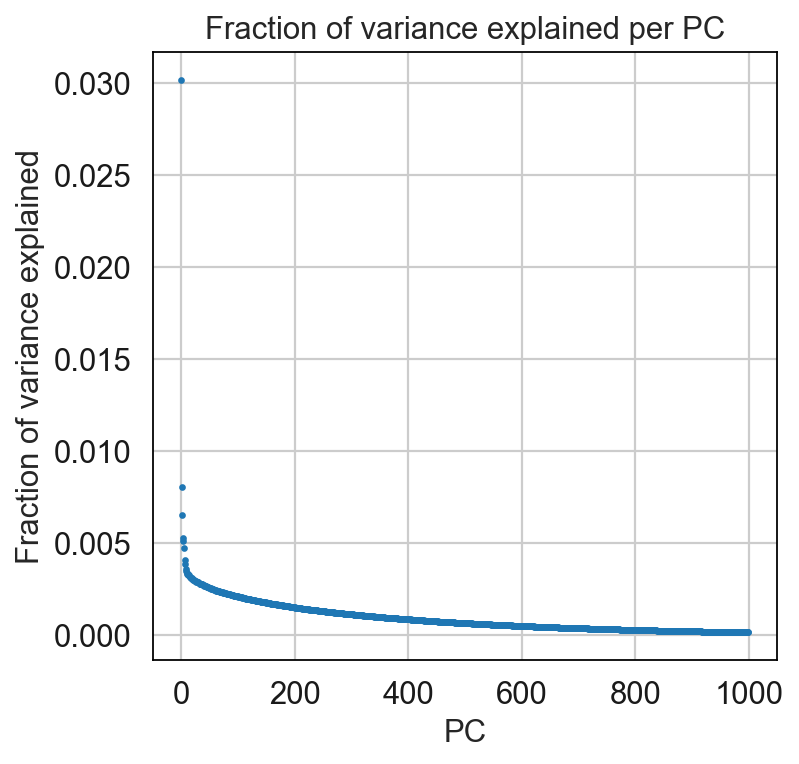

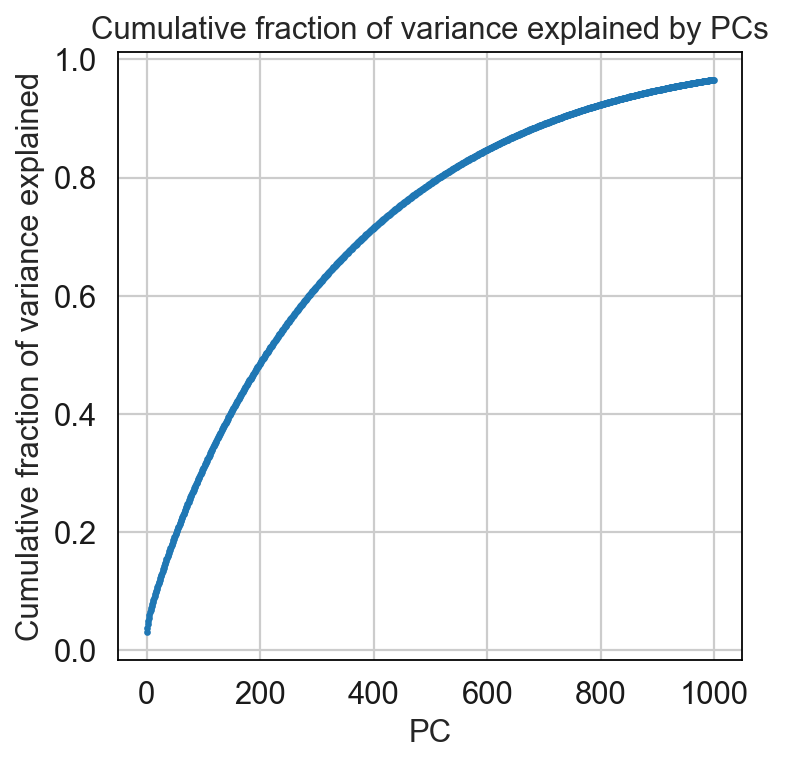

Knee point: 15
Explained variance: 0.09464926


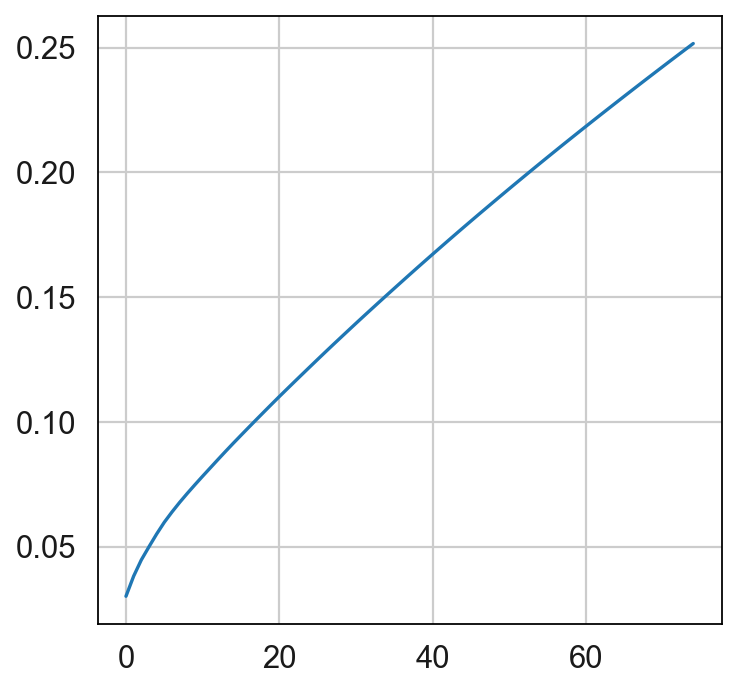

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


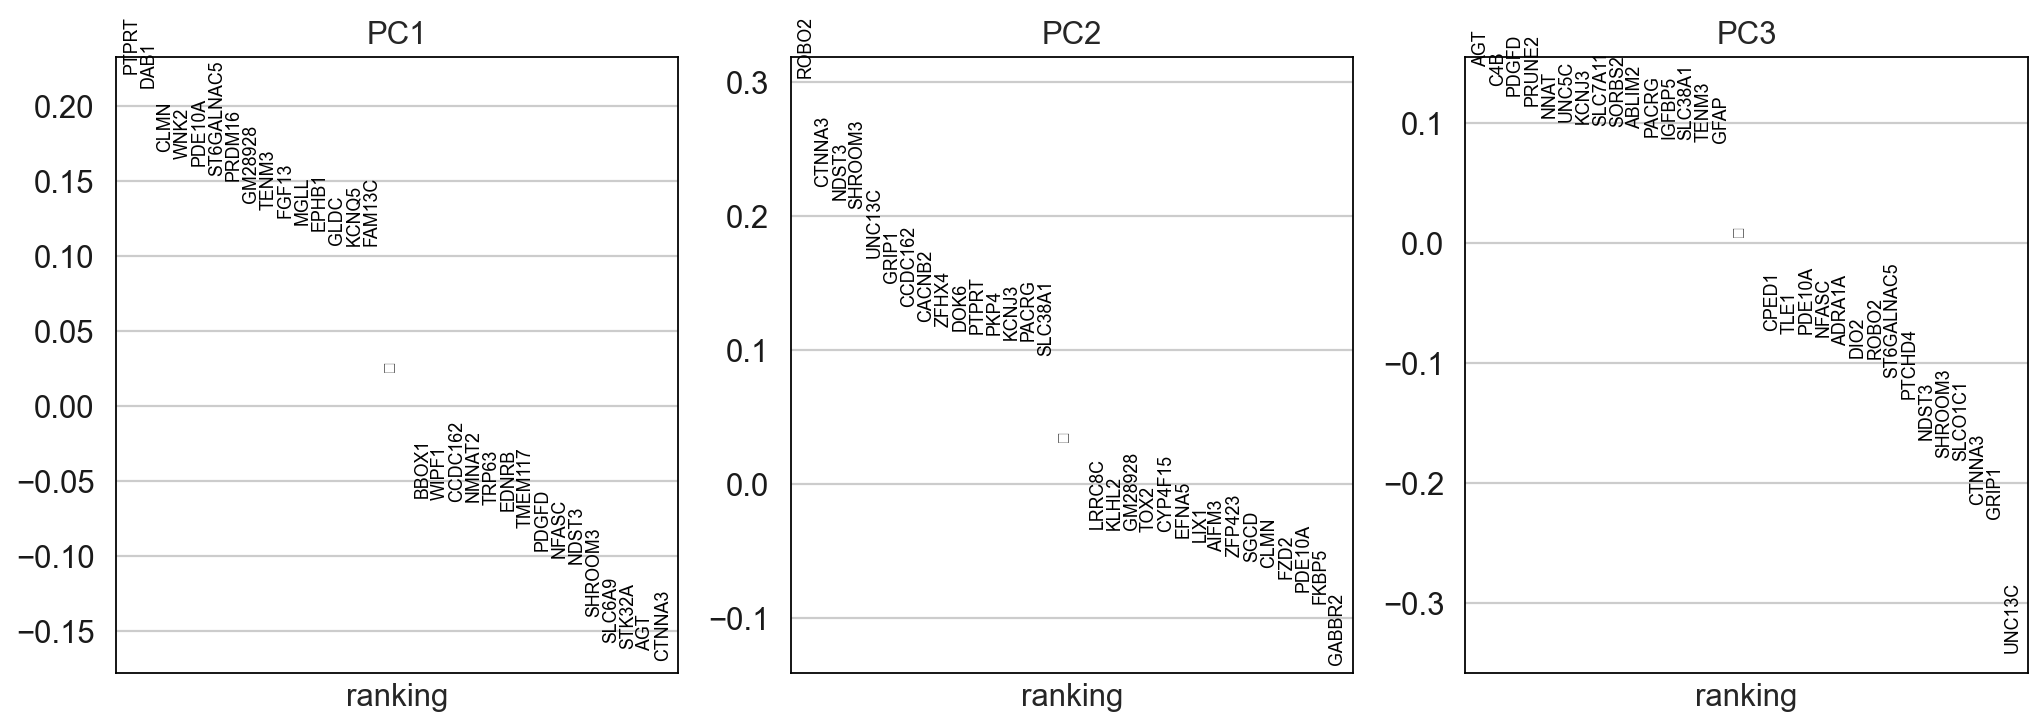

(1628, 12353)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc.set_figure_params(figsize=(5, 5))
adata_astro = run_pca_knee(adata_astro)#, 0.5)
adata_astro.obs['PC 1'] = adata_astro.obsm['X_pca'][:,0] # optional
adata_astro.obs['PC 2'] = adata_astro.obsm['X_pca'][:,1]
adata_astro.obs['PC 3'] = adata_astro.obsm['X_pca'][:,2]

print(adata_astro.shape)
adata_astro.X = pd.DataFrame(adata_astro.X).fillna(0).values
index_list = np.arange(adata_astro.shape[0])
np.random.shuffle(index_list)
adata_astro = adata_astro[index_list,:]

In [22]:
print(adata_astro.shape)
adata_astro.X = pd.DataFrame(adata_astro.X).fillna(0).values
index_list = np.arange(adata_astro.shape[0])
np.random.shuffle(index_list)
adata_astro = adata_astro[index_list,:]

(1628, 12353)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.08170819282531738 seconds
Jaccard graph constructed in 1.6704151630401611 seconds
Wrote graph to binary file in 0.022313833236694336 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742551
After 6 runs, maximum modularity is Q = 0.743769
After 7 runs, maximum modularity is Q = 0.744937
After 15 runs, maximum modularity is Q = 0.745984
Louvain completed 35 runs in 0.8764400482177734 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.2950549125671387 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.040495872497558594 seconds
Jaccard graph constructed in 0.8122310638427734 seconds
Wrote graph to binary file in 0.14718294143676758 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.706321
Louvain completed 21 runs in 0.5361459255218506 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.1724581718444824 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.04127788543701172 seconds
Jaccard graph constructed in 0.8310191631317139 seconds
Wrote graph to binary file in 0.04880070686340332 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.672176
After 2 runs, maximum modularity is Q = 0.680132
Louvain completed 22 runs in 0.6324043273925781 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.1816530227661133 seco

Text(0.5, 0, 'k')

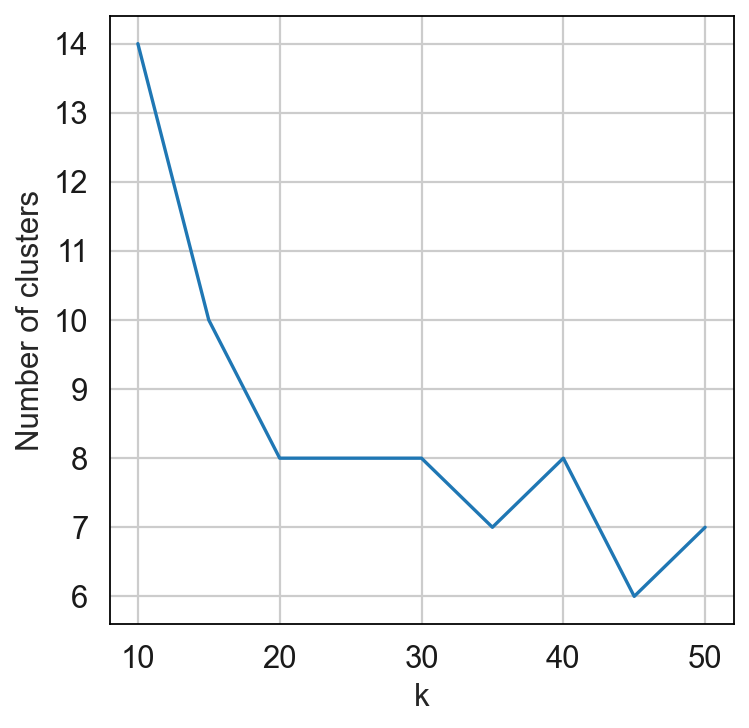

In [23]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_astro.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_astro.obs['PhenoGraph_clusters_astro'+str(k)] = pd.Categorical(communities)
    adata_astro.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_astro.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [24]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_astro.obs['PhenoGraph_clusters_astro'+str(k_list[run1])].values,
            adata_astro.obs['PhenoGraph_clusters_astro'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

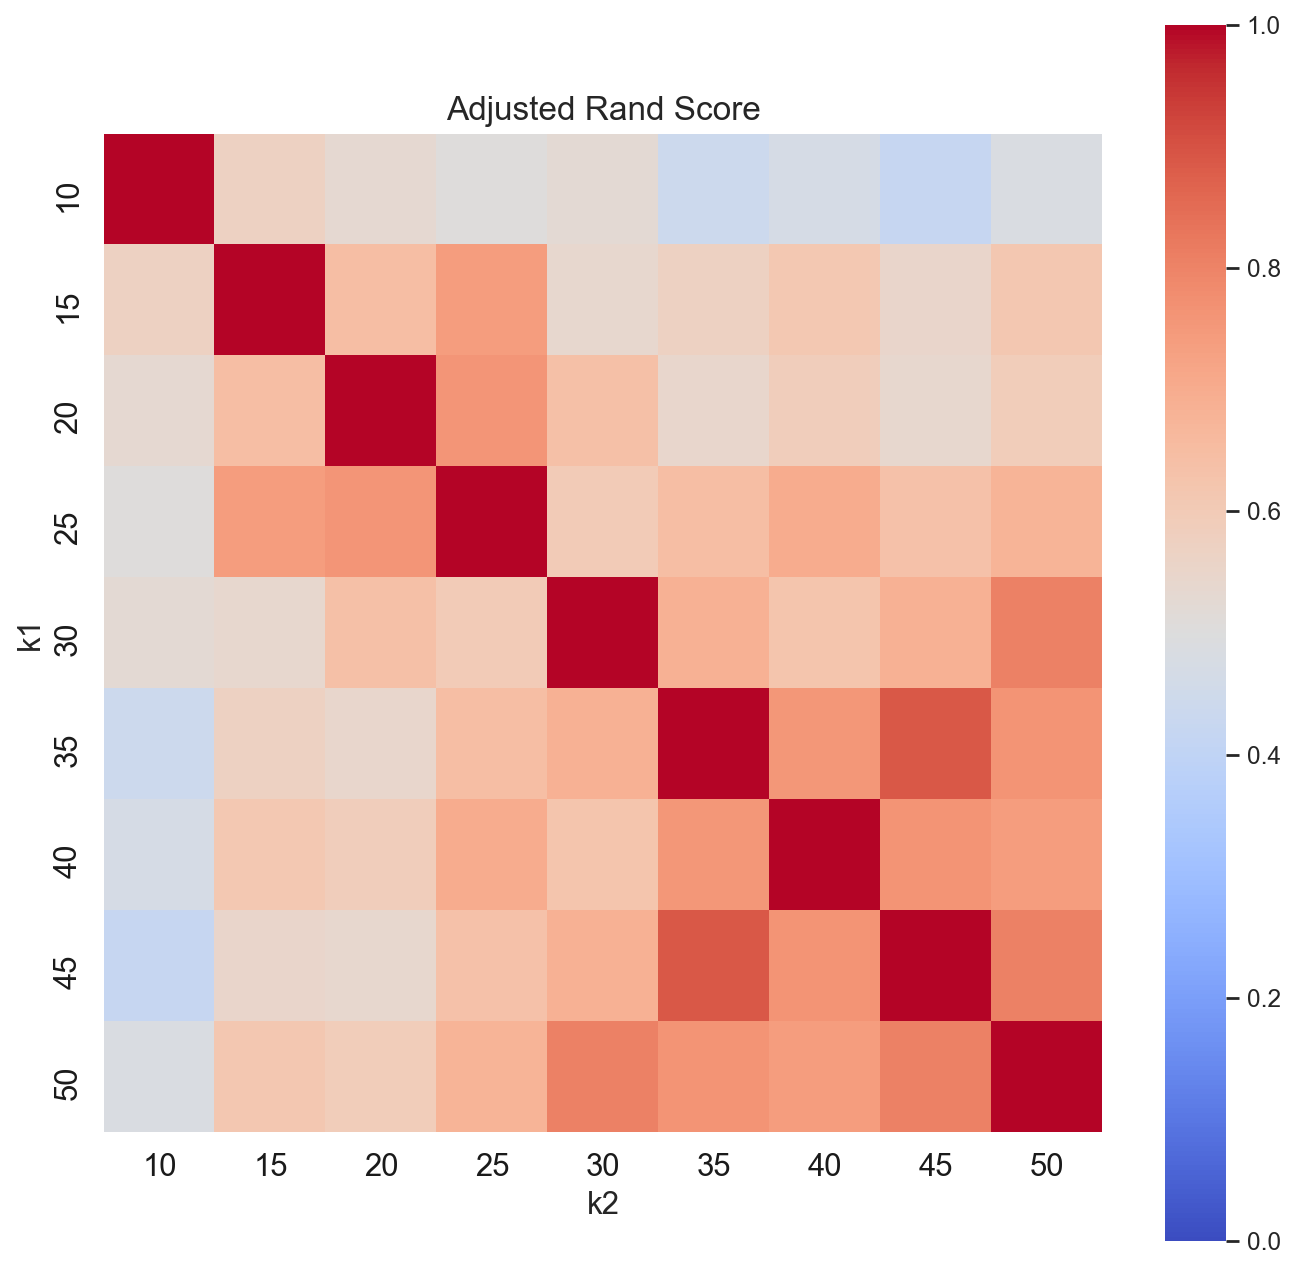

In [25]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [26]:
k = 45 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_astro.obsm['X_pca']),k=k) # run PhenoGraph
adata_astro.obs['PhenoGraph_clusters_astro'] = pd.Categorical(communities)
adata_astro.uns['PhenoGraph_Q'] = Q
adata_astro.uns['PhenoGraph_k'] = k

Finding 45 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.04285383224487305 seconds
Jaccard graph constructed in 1.0896649360656738 seconds
Wrote graph to binary file in 0.18216705322265625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.616936
After 3 runs, maximum modularity is Q = 0.619214
After 4 runs, maximum modularity is Q = 0.623531
Louvain completed 24 runs in 0.8446030616760254 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.819847822189331 seconds


## Vizualize Astrocyte sub-clusters

In [27]:
sc.pp.neighbors(adata_astro, method='umap', use_rep='X_pca')
sc.tl.umap(adata_astro, random_state=None)

... storing 'Condition' as categorical
... storing 'B_region' as categorical


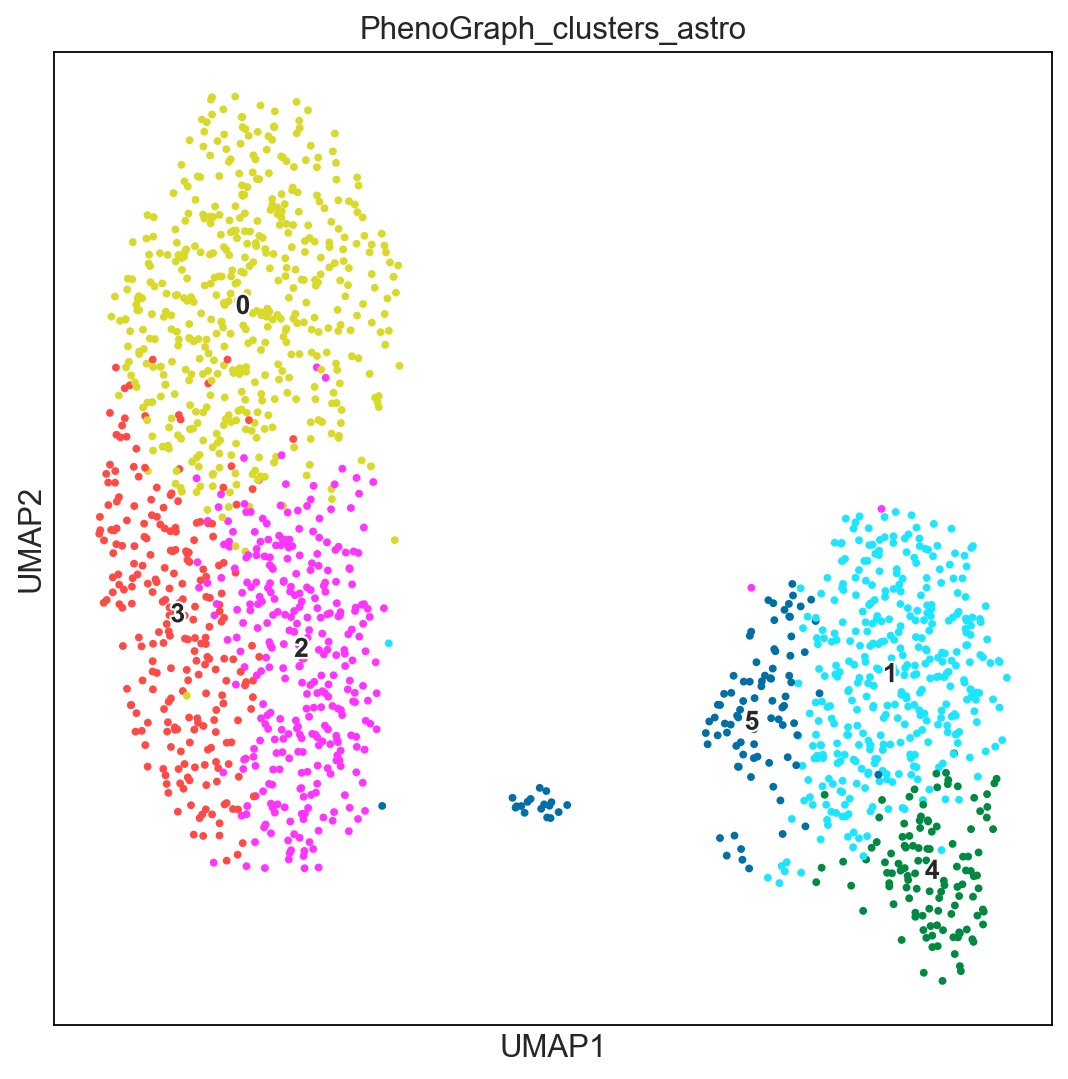

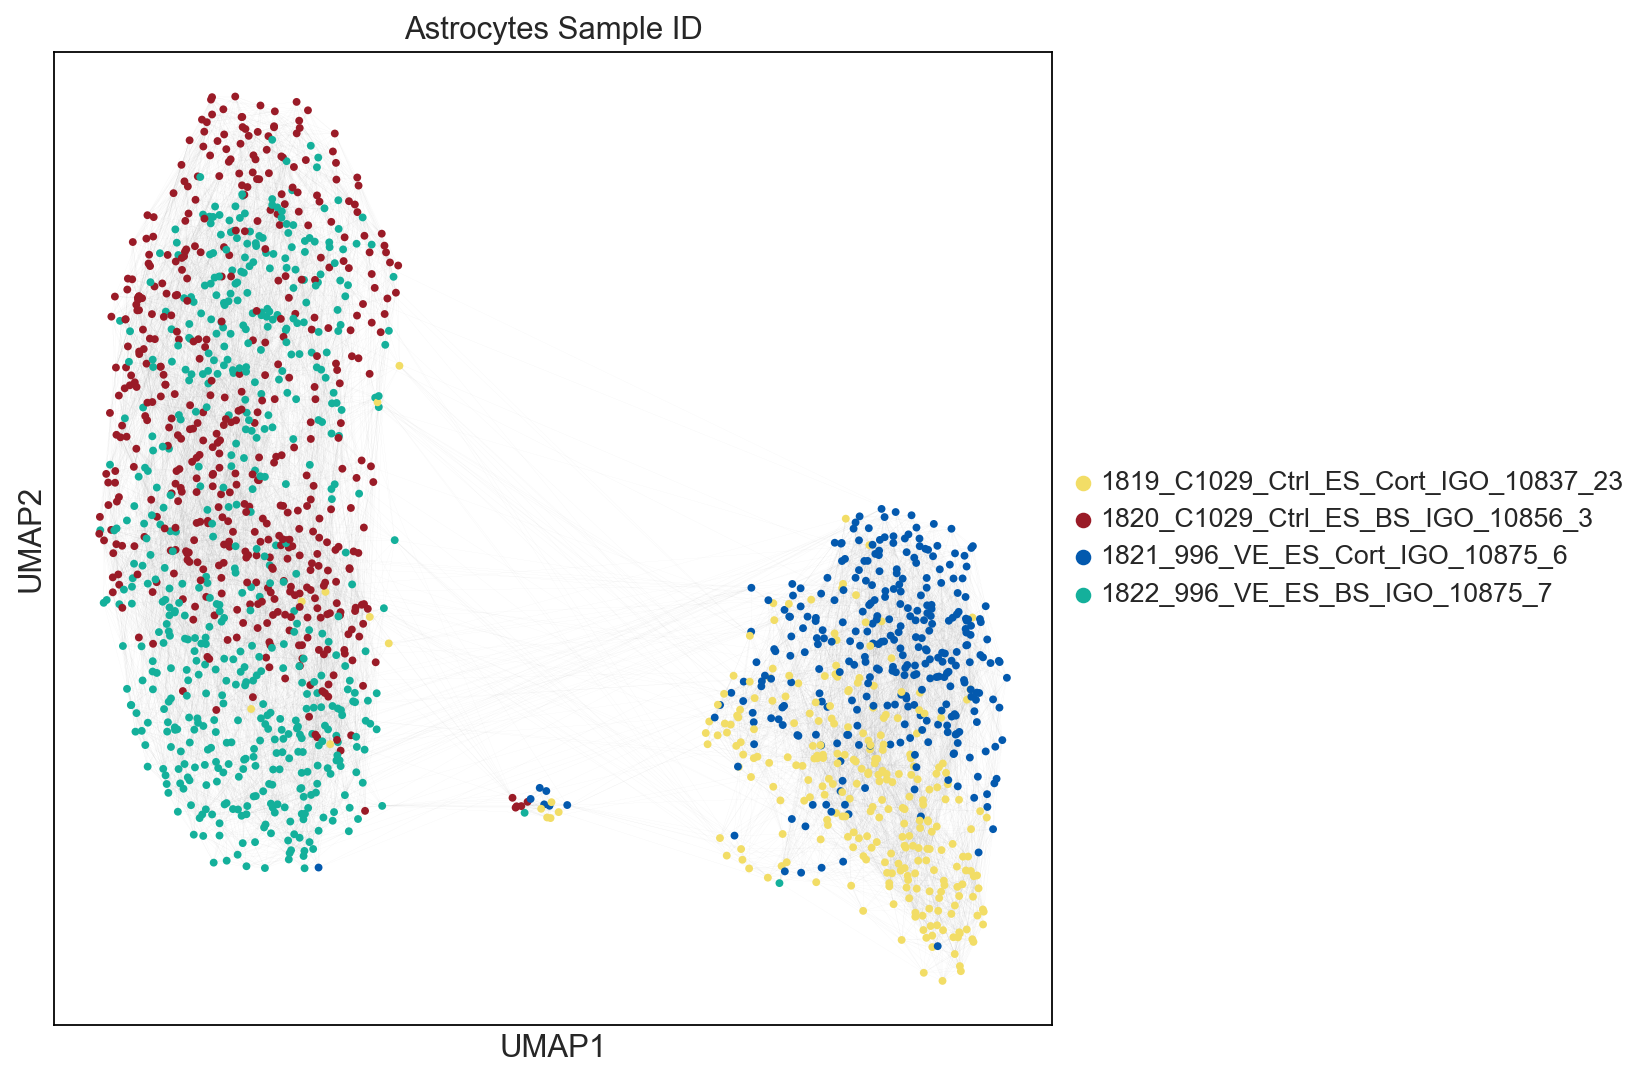

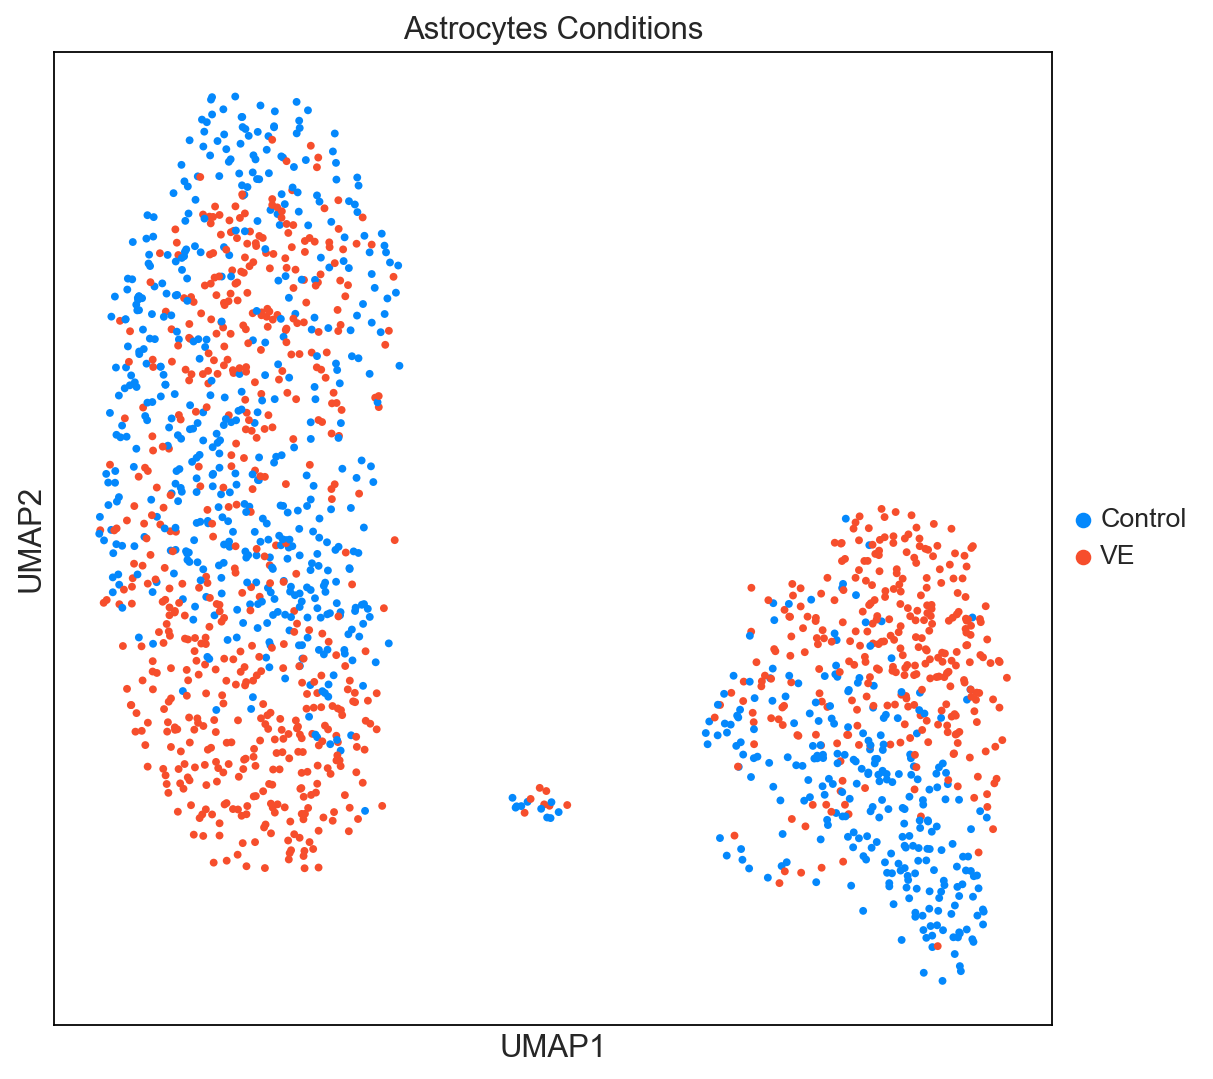

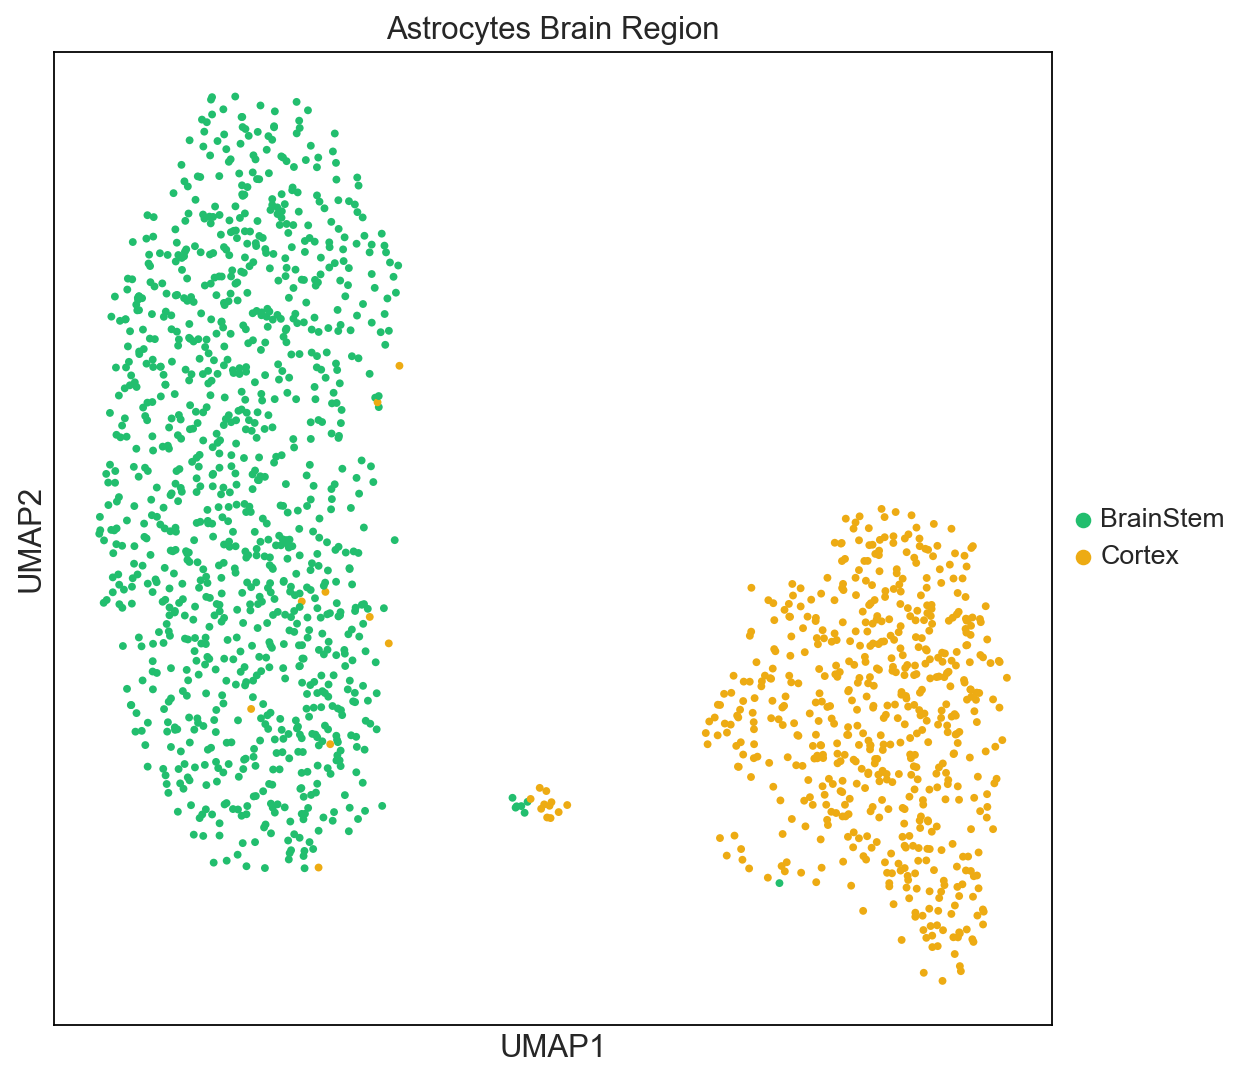

In [28]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(
    adata_astro,
    color=['PhenoGraph_clusters_astro'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette=godsnot_64, # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12, size = 50,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)

sc.pl.umap(adata_astro, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_astro,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 50, frameon = True,
           legend_fontoutline=2,
          title=["Astrocytes Conditions"])

sc.pl.umap(adata_astro, 
           color= ['B_region'],
           ncols=2,
           palette= ["#22BE6E", "#EDAB13"],
           size=50, 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Brain Region"])


## Find markers (Oligo clusters)

In [31]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Astro0',
    1 : 'Astro1',
    2 : 'Astro2',
    3 : 'Astro3',
    4 : 'Astro4',
    5 : 'Astro5'}

adata_astro.obs['PhenoGraph_clusters_astro_str'] = adata_astro.obs['PhenoGraph_clusters_astro'].map(cl_int_to_str).astype('category')

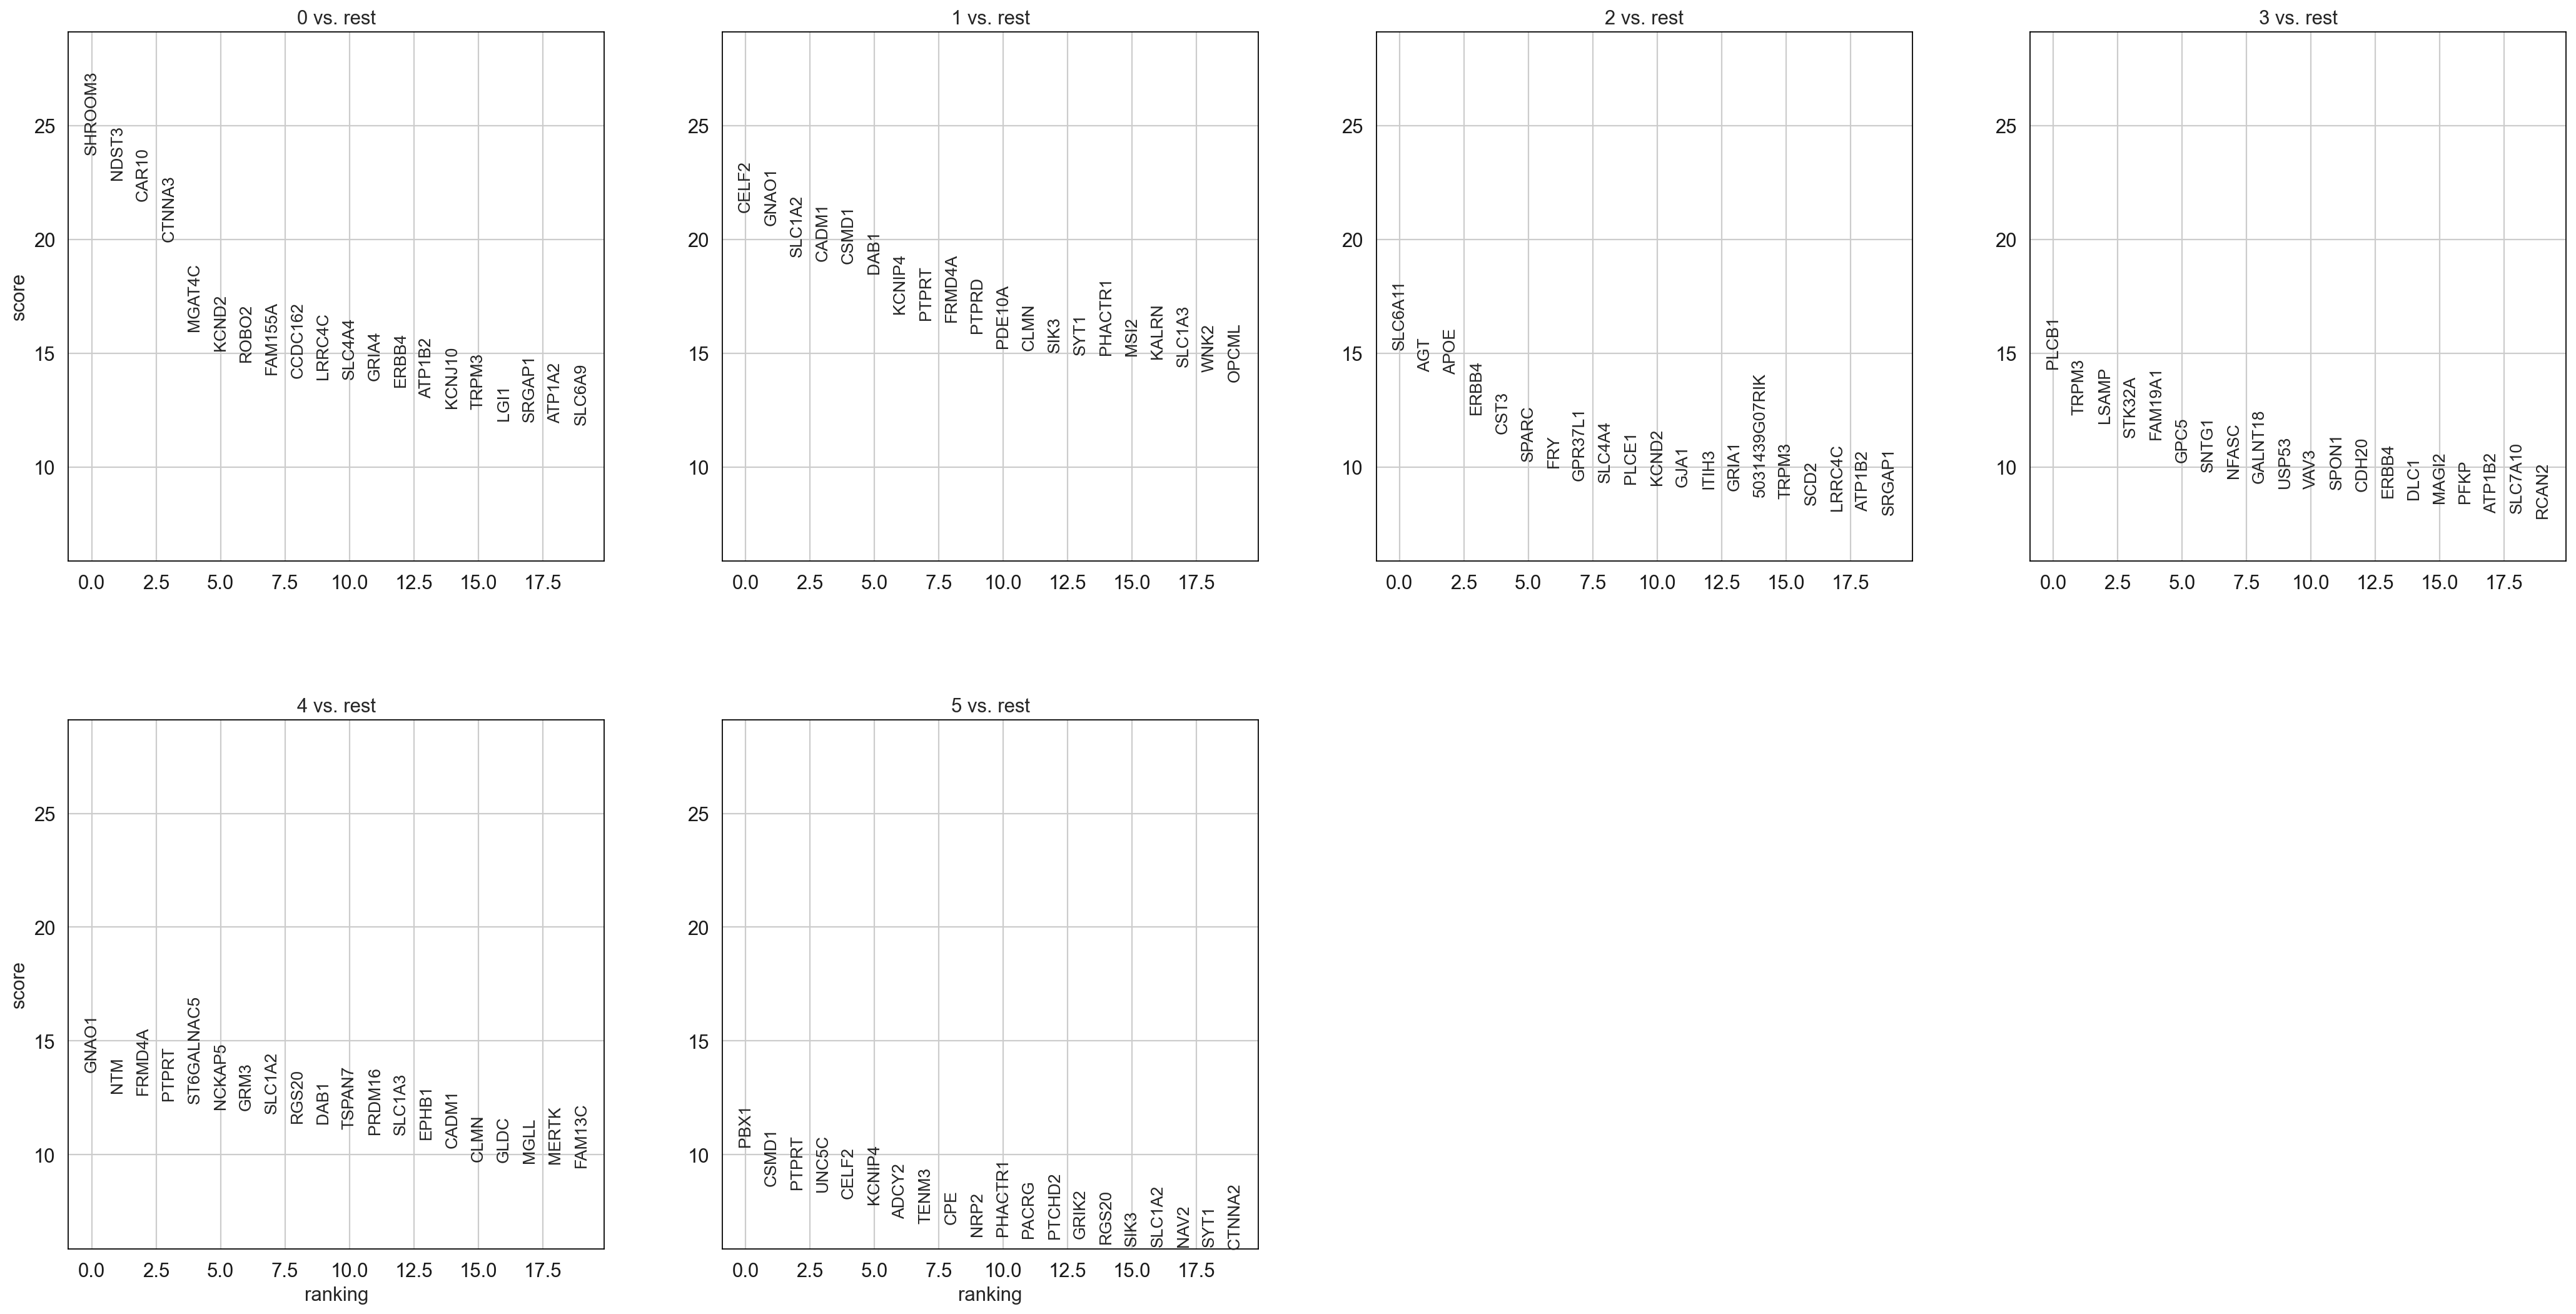

In [32]:
sc.tl.rank_genes_groups(adata_astro, groupby='PhenoGraph_clusters_astro', key_added="ranked_genes_pheno_astro", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro, key = 'ranked_genes_pheno_astro', fontsize=12)

## Visualize marker genes using heatmap

In [33]:
adata_astro.layers['scaled'] = sc.pp.scale(adata_astro, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_astro_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

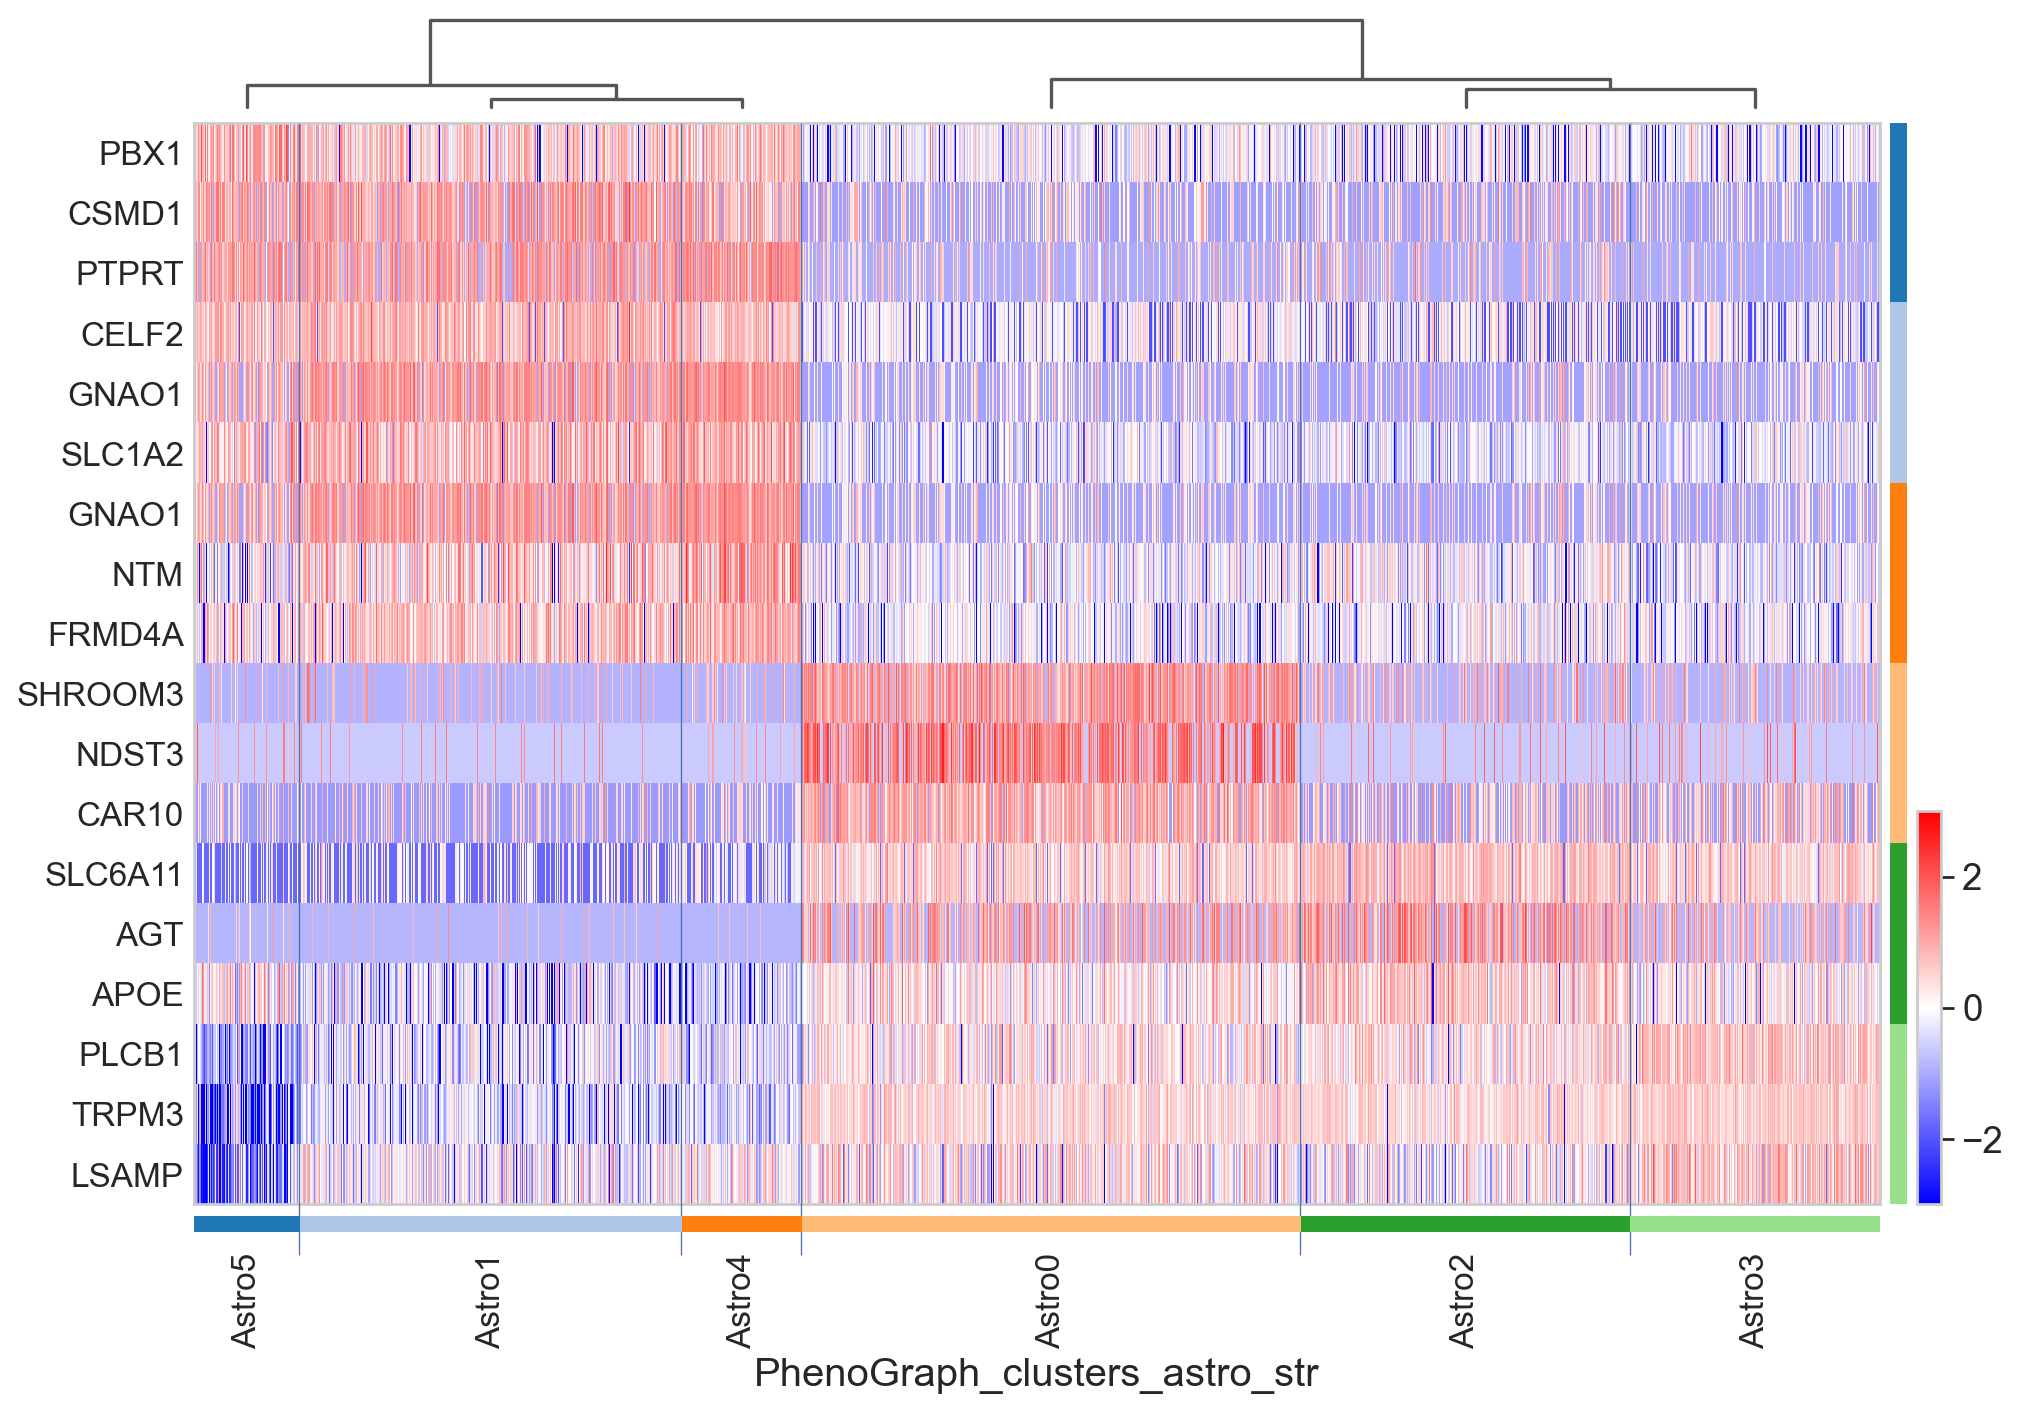

In [65]:
sc.tl.rank_genes_groups(adata_astro, groupby='PhenoGraph_clusters_astro_str', n_genes=adata_astro.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_astro, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

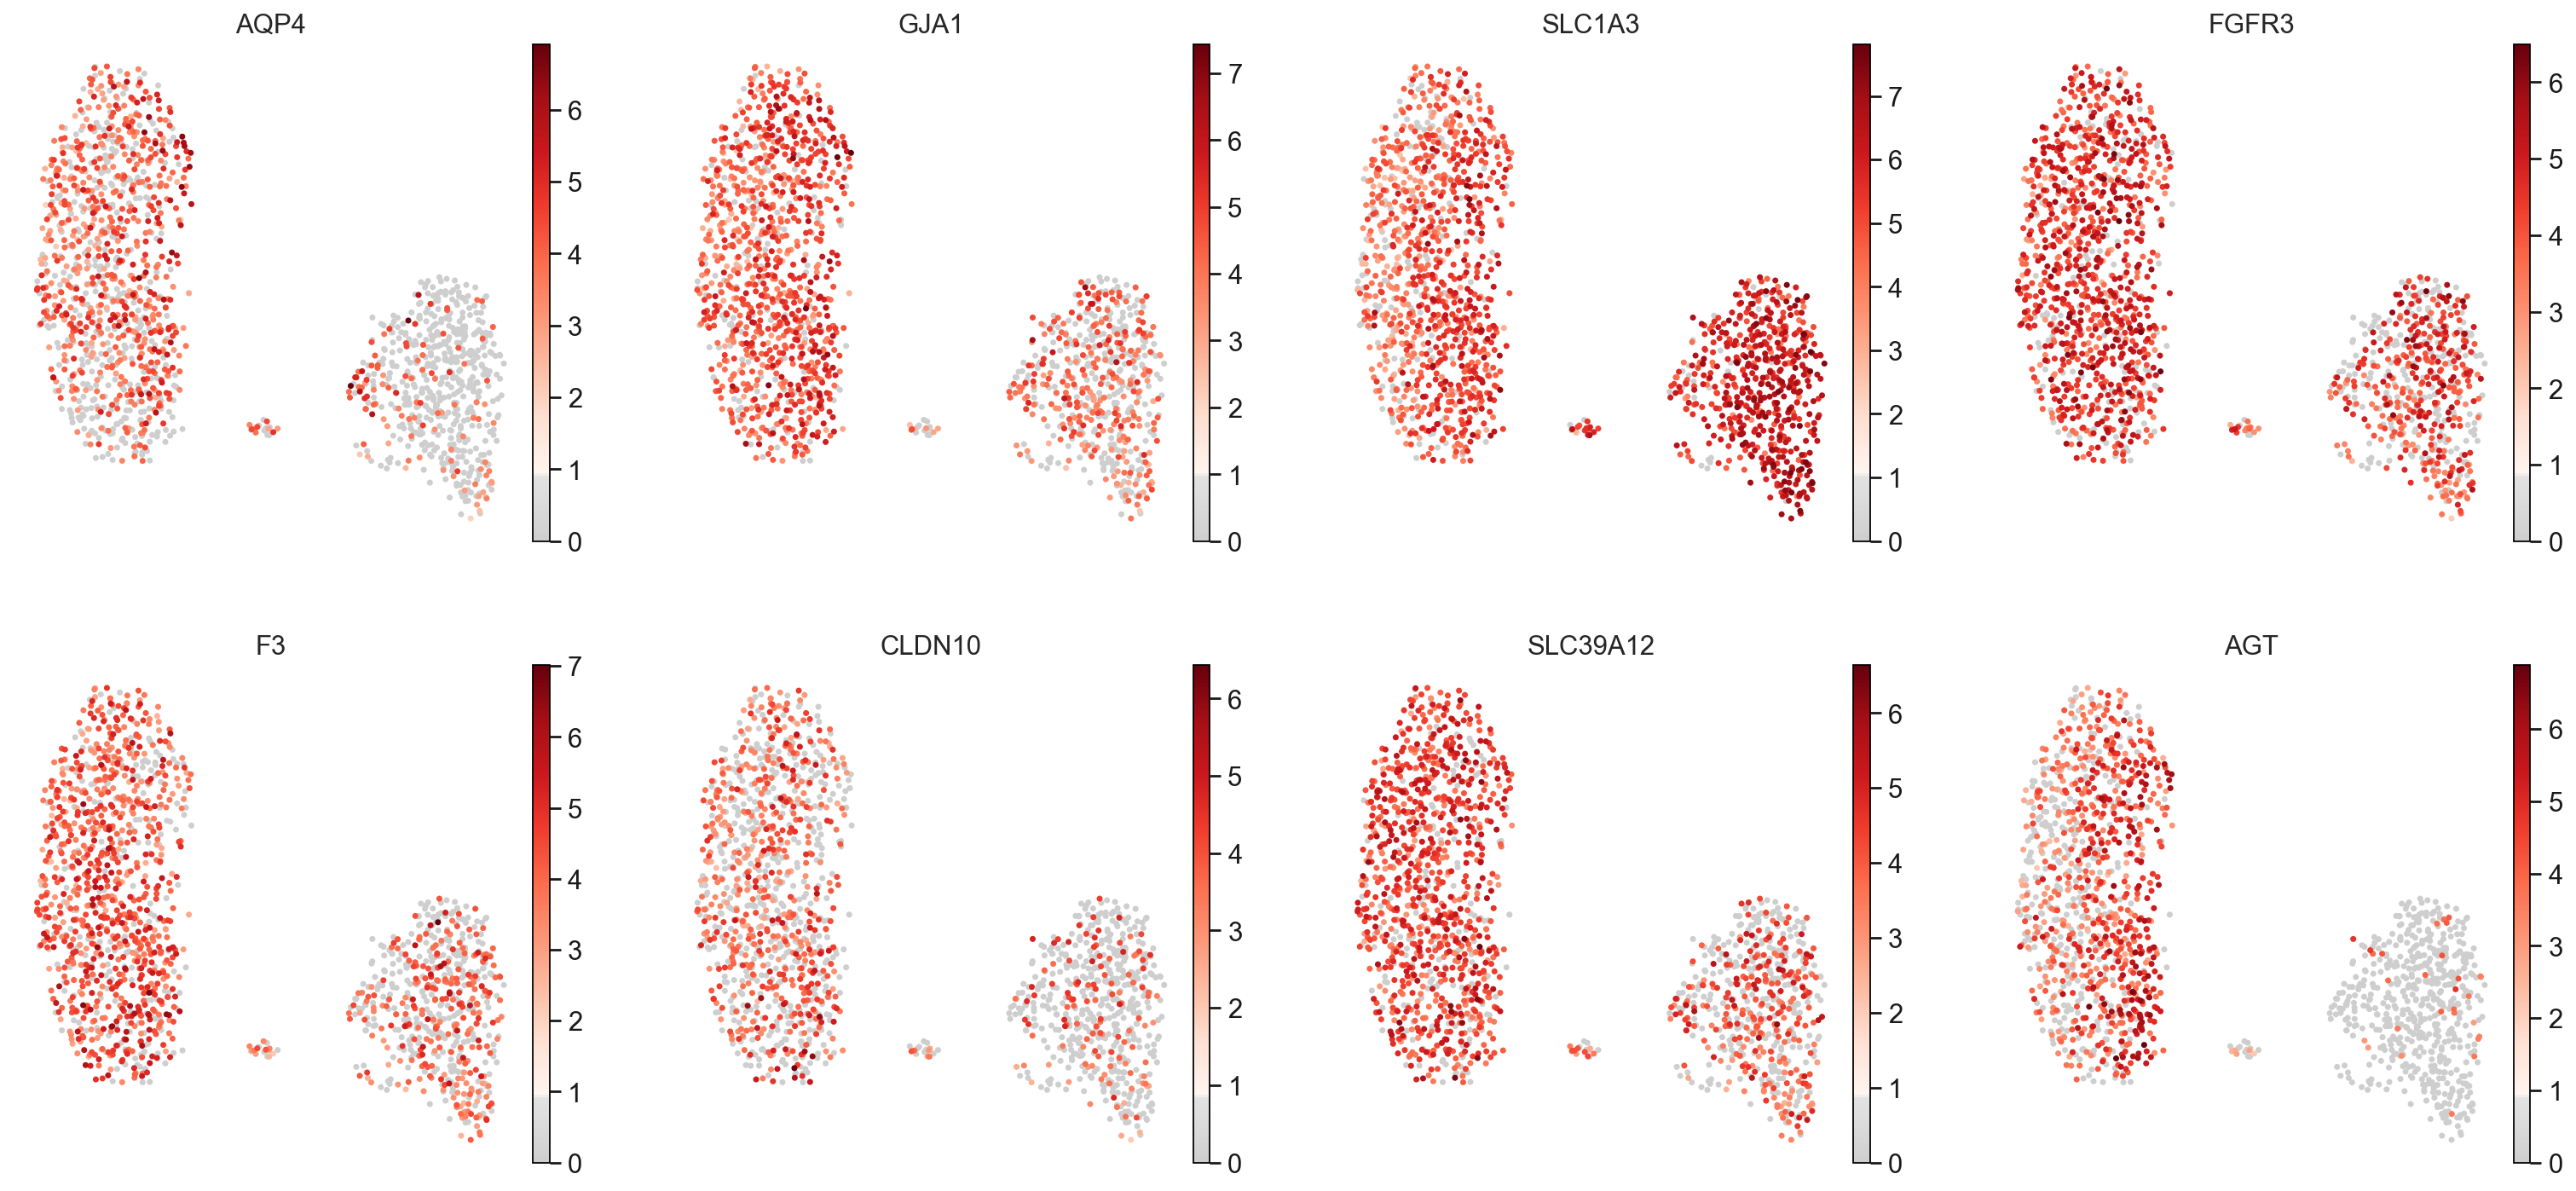

In [13]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_astro,
           size = 40,
           color=['AQP4','GJA1','SLC1A3','FGFR3','F3', 'CLDN10', 'SLC39A12', 'AGT'],
           color_map=mymap,
          frameon=False)

In [36]:
adata_astro.obs.PhenoGraph_clusters_astro.value_counts()

0    482
1    369
2    318
3    241
4    116
5    102
Name: PhenoGraph_clusters_astro, dtype: int64

## Save result Adata Astrocytes

In [37]:
#adata_astro.write_h5ad(outdir+'adata_high_var_Astro_diff_norm_clusters.h5ad')

In [24]:
adata_astro = sc.read_h5ad(outdir+'adata_high_var_Astro_diff_norm_clusters.h5ad')

## Astrocytes Cortex

In [111]:
adata_astro_cortex = adata_astro.copy()
adata_astro_cortex = adata_astro_cortex[adata_astro_cortex.obs['B_region'].isin(['Cortex']),:]
adata_astro_cortex.shape

(589, 12353)

In [112]:
adata_astro_cortex.obs.Condition.value_counts()

VE         314
Control    275
Name: Condition, dtype: int64

Trying to set attribute `.uns` of view, copying.


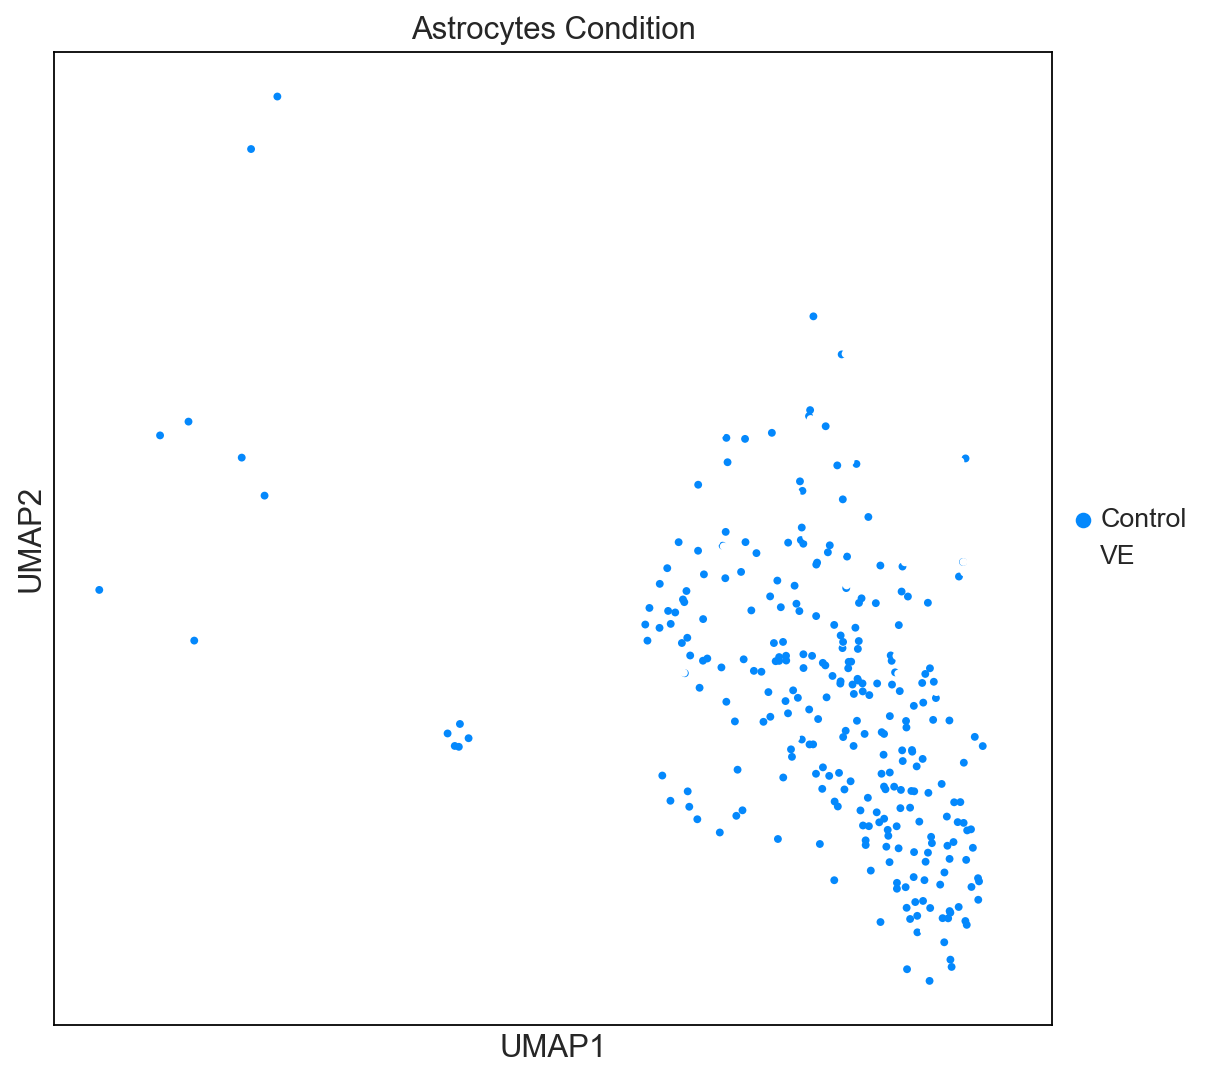

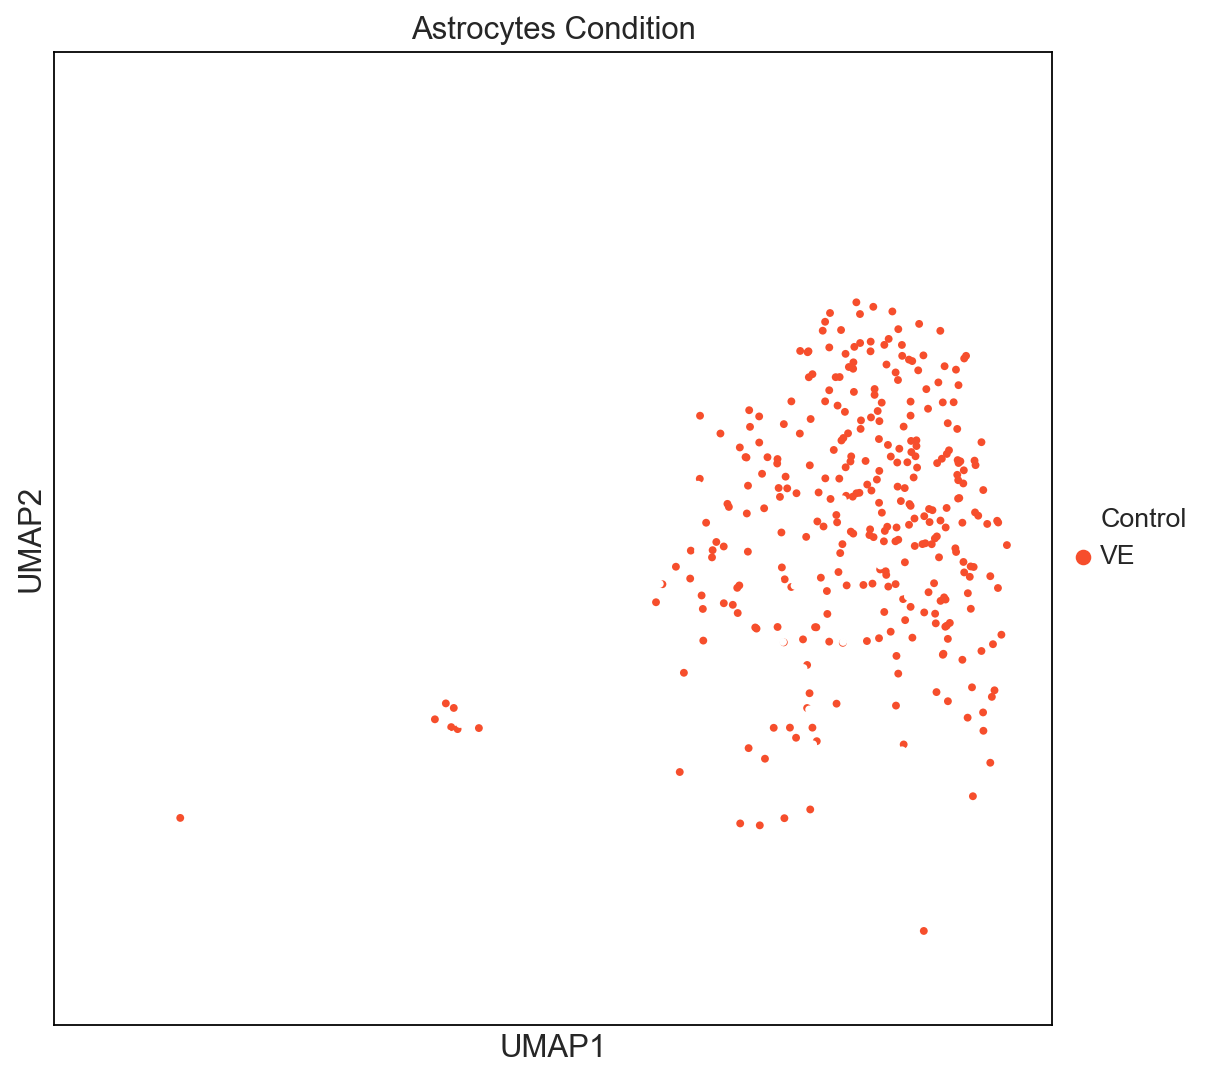

In [113]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Condition"])


sc.pl.umap(adata_astro_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Condition"])

#### Astrocytes cortex control

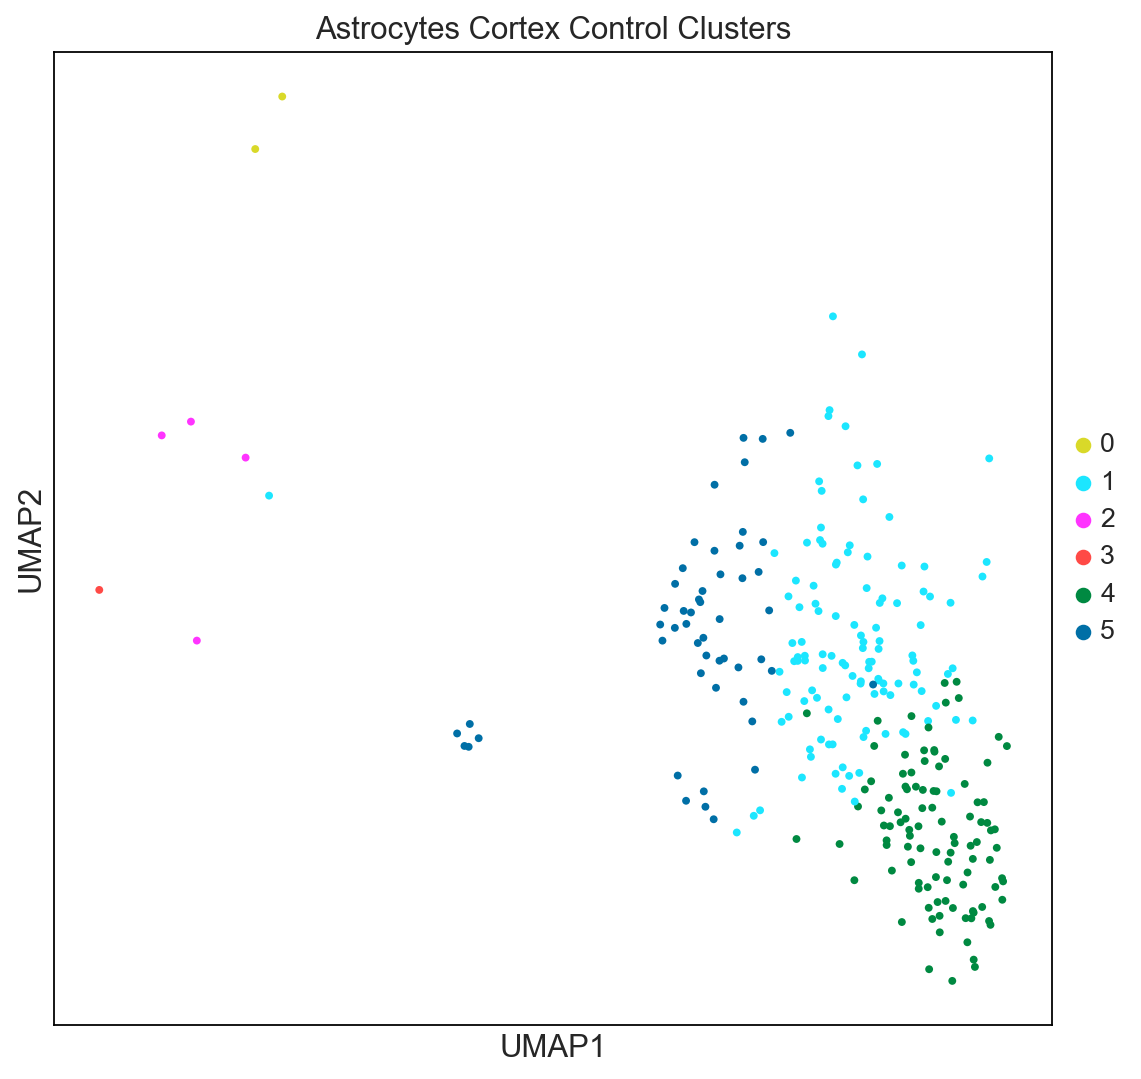

In [114]:
adata_astro_cortex_control = adata_astro_cortex[adata_astro_cortex.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_cortex_control, 
           color= ['PhenoGraph_clusters_astro'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Cortex Control Clusters"])

In [115]:
cell_counts_per_cluster_cortex_ctrl = adata_astro_cortex_control.obs.PhenoGraph_clusters_astro.value_counts()
cell_counts_per_cluster_cortex_ctrl = cell_counts_per_cluster_cortex_ctrl.to_frame()
cell_counts_per_cluster_cortex_ctrl

PhenoGraph_clusters_astro
1                        116
4                        101
5                         51
2                          4
0                          2
3                          1

#### Astrocyte Cortex VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


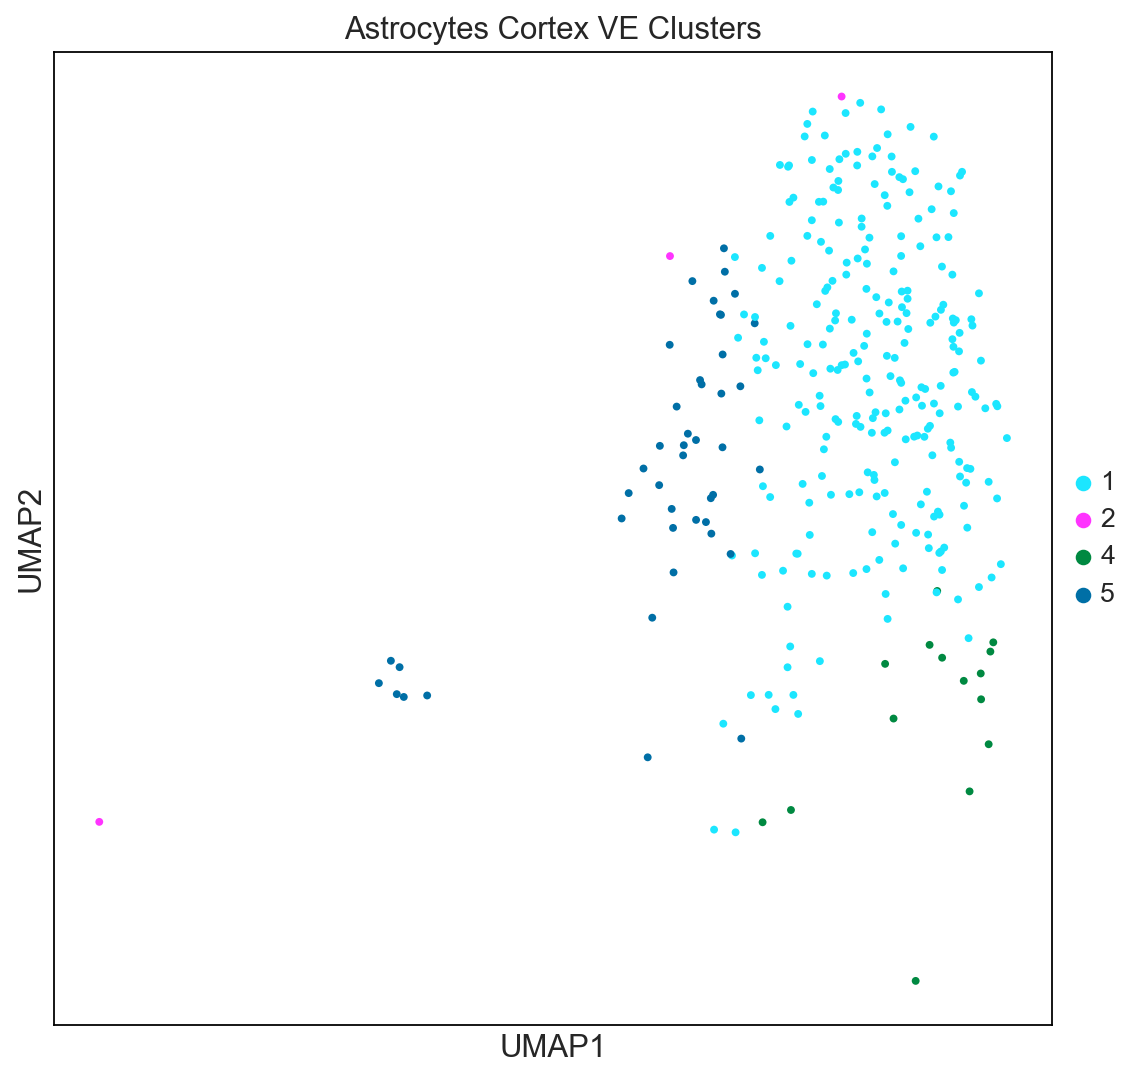

In [116]:
adata_astro_cortex_VE = adata_astro_cortex[adata_astro_cortex.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_cortex_VE, 
           color= ['PhenoGraph_clusters_astro'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette= ["#1CE6FF", "#FF34FF", "#008941", "#006FA6"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Cortex VE Clusters"])

In [117]:
cell_counts_per_cluster_cortex_VE = adata_astro_cortex_VE.obs.PhenoGraph_clusters_astro.value_counts()
cell_counts_per_cluster_cortex_VE = cell_counts_per_cluster_cortex_VE.to_frame()
cell_counts_per_cluster_cortex_VE

PhenoGraph_clusters_astro
1                        252
5                         44
4                         15
2                          3

### Heatmaps of gene expression

In [57]:
marker_genes_dict = dict()

marker_genes_dict = {'Astro-Cortex':['PDE10A',
'FKBP5',
'CCND3',
'MAT2A',
'TTYH1',
'ZBTB16',
'PRKCA',
'CDH19',
'ASIC2',
'HNRNPA2B1',
'GALNT18',
'GABBR2',
'NRG1',
'CLMN',
'CYP4F15',
'SLC24A4',
'MDGA2',
'NEAT1',
'GPATCH8']}





categories: Astro0_Control, Astro1_Control, Astro1_VE, etc.
var_group_labels: Astro-Cortex


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


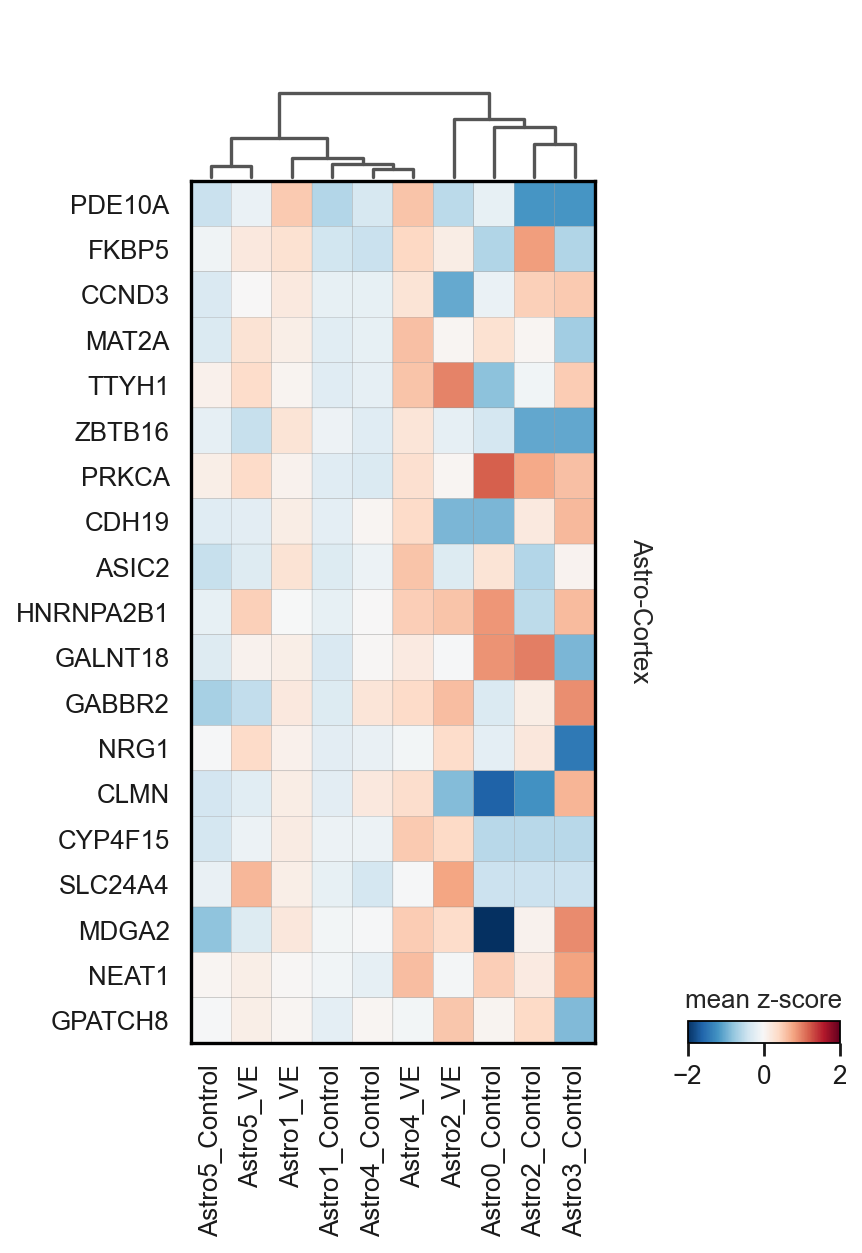

categories: Astro0_Control, Astro1_Control, Astro1_VE, etc.
var_group_labels: Astro-Cortex


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


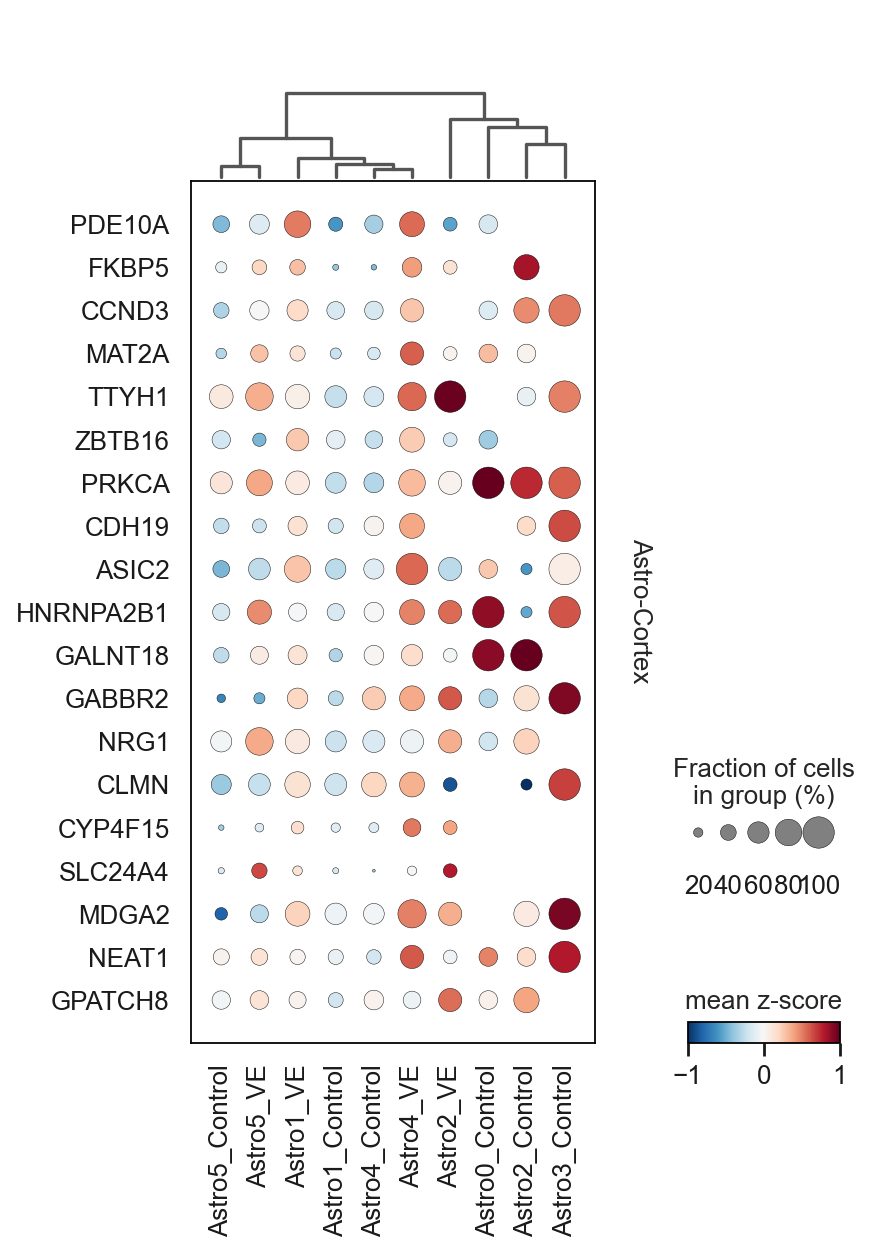

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


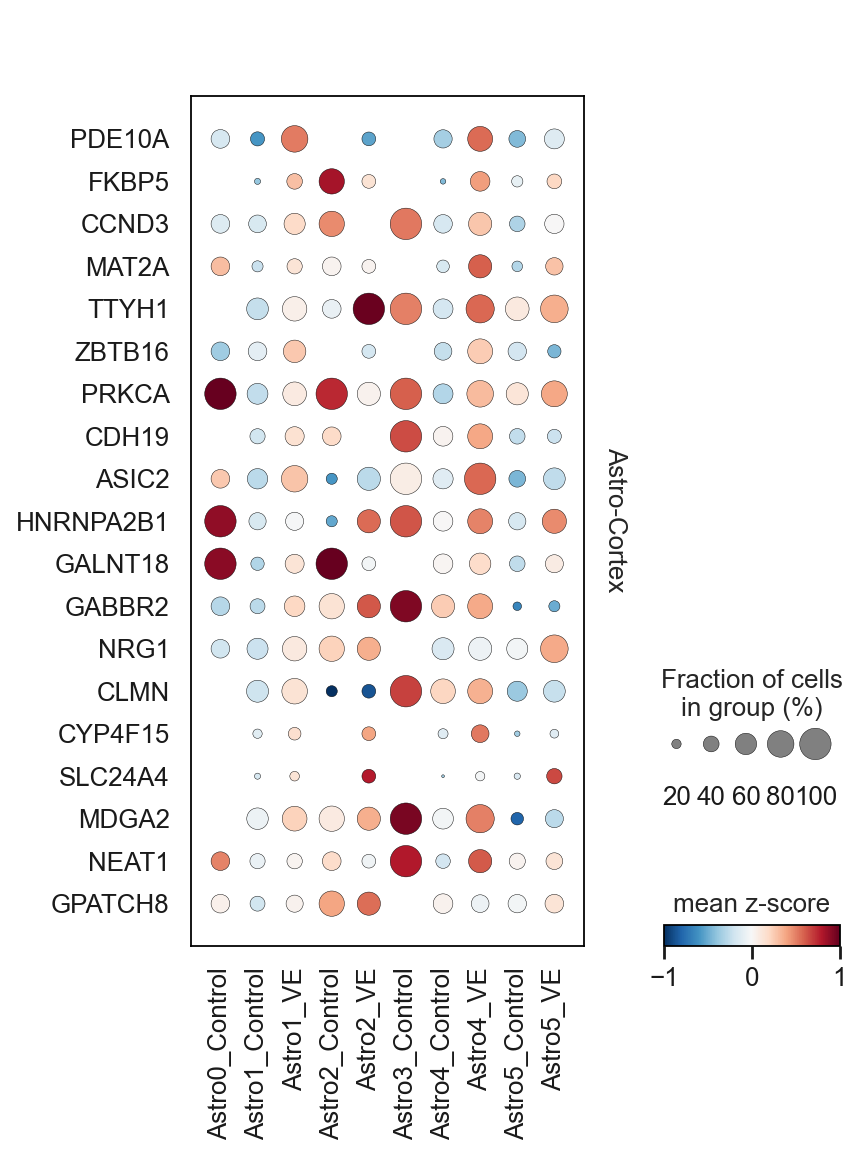

In [58]:
adata_astro_cortex.layers['scaled'] = sc.pp.scale(adata_astro_cortex, copy=True).X
sc.pl.matrixplot(adata_astro_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Make a grouped bar plot of the number of cells per cluster per condition

**Cortex**

In [124]:
# First merge the 2 data frames by indeces
mergedDF_2= cell_counts_per_cluster_cortex_ctrl.merge(cell_counts_per_cluster_cortex_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'), how = 'outer')
mergedDF_2.rename(columns = {'PhenoGraph_clusters_astro_Control' : 'Control', 'PhenoGraph_clusters_astro_VE' : 'VE'}, inplace = True)
mergedDF_2

Control     VE
0        2    NaN
1      116  252.0
2        4    3.0
3        1    NaN
4      101   15.0
5       51   44.0

In [125]:
mergedDF_2 = mergedDF_2.reset_index()
mergedDF_2 = mergedDF_2.melt(id_vars=["index"])
mergedDF_2.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF_2

ClusterID Condition  N_cells
0           0   Control      2.0
1           1   Control    116.0
2           2   Control      4.0
3           3   Control      1.0
4           4   Control    101.0
5           5   Control     51.0
6           0        VE      NaN
7           1        VE    252.0
8           2        VE      3.0
9           3        VE      NaN
10          4        VE     15.0
11          5        VE     44.0

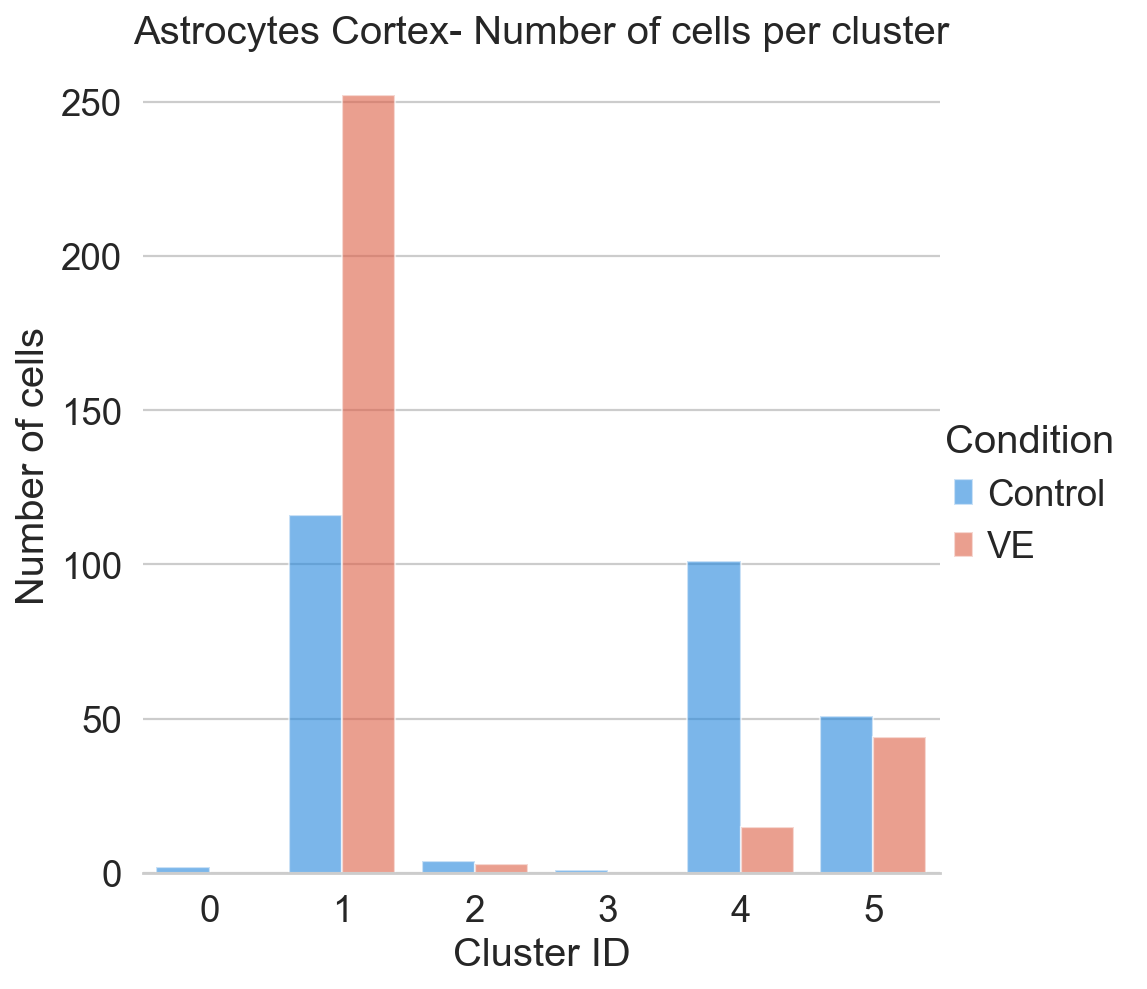

In [126]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF_2, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Astrocytes Cortex- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")